In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# Change to the directory of your project
project_path = '/content/drive/MyDrive/Labelled_Multiclass_Dataset'
os.chdir(project_path)

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Labelled_Multiclass_Dataset/combined_data_without_okpVacc.csv')

In [5]:
data.head()

,Unnamed: 0,device_id,session_id,src_ip,dst_ip,src_port,dst_port,protocol,timestamp,flow_duration,...,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,cwr_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,Label
0,0,1,192.168.1.215-255.255.255.255-49154-6667-17,192.168.1.215,255.255.255.255,49154,6667,17,14-08-2024 8:00,120013552,...,0.0,0.0,230.000000,0.0,0,22,0,5060,0,Benign
1,1,1,192.168.1.192-131.100.0.205-50458-5938-6,192.168.1.192,131.100.0.205,50458,5938,6,14-08-2024 8:00,110128079,...,0.0,0.0,81.000000,75.0,0,8,8,648,600,Benign
2,2,1,192.168.1.102-255.255.255.255-9487-9478-17,192.168.1.102,255.255.255.255,9487,9478,17,14-08-2024 8:00,120012804,...,0.0,0.0,82.000000,0.0,0,2,0,164,0,Benign
3,3,1,192.168.1.102-224.0.0.251-5353-5353-17,192.168.1.102,224.0.0.251,5353,5353,17,14-08-2024 8:01,101790420,...,0.0,0.0,177.357143,0.0,0,14,0,2483,0,Benign
4,4,1,192.168.1.243-255.255.255.255-5683-5683-17,192.168.1.243,255.255.255.255,5683,5683,17,14-08-2024 8:01,125747851,...,0.0,0.0,139.000000,0.0,0,7,0,973,0,Benign


In [6]:
data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
drop_columns = [
    "id"
   ]
data.drop(columns=drop_columns, inplace=True, errors='ignore')

In [7]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

<ipython-input-7-6a2033506dc8>:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')


In [8]:
print(data['timestamp'].isnull().sum())
print(data['timestamp'].head())

0
0   2024-08-14 08:00:00
1   2024-08-14 08:00:00
2   2024-08-14 08:00:00
3   2024-08-14 08:01:00
4   2024-08-14 08:01:00
Name: timestamp, dtype: datetime64[ns]


In [9]:
# Define window size (e.g., 1 minute) and step size (e.g., 30 seconds)
window_size = pd.Timedelta('1T')  # 1 minute window
step_size = pd.Timedelta('30S')   # 30-second sliding step

In [10]:
# Set the timestamp as the index for resampling
data.set_index('timestamp', inplace=True)

In [11]:
# Aggregation function for session-based, direction-specific, and total packet/byte calculations
session_data = data.groupby(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol']).agg(
    # Session-based aggregations
    flow_duration=('flow_duration', 'sum'),
    total_forward_packets=('tot_fwd_pkts', 'sum'),
    total_backward_packets=('tot_bwd_pkts', 'sum'),
    total_bytes_forward=('totlen_fwd_pkts', 'sum'),
    total_bytes_backward=('totlen_bwd_pkts', 'sum'),
    mean_packet_length_forward=('fwd_pkt_len_mean', 'mean'),
    mean_packet_length_backward=('bwd_pkt_len_mean', 'mean'),
    packet_size_mean=('pkt_len_mean', 'mean'),
    flow_iat_mean=('flow_iat_mean', 'mean'),
    down_up_ratio=('down_up_ratio', 'mean'),
    subflow_fwd_pkts=('subflow_fwd_pkts', 'sum'),
    subflow_bwd_pkts=('subflow_bwd_pkts', 'sum'),
    subflow_fwd_byts=('subflow_fwd_byts', 'sum'),
    subflow_bwd_byts=('subflow_bwd_byts', 'sum'),

    # Direction-specific aggregations (Forward flows)
    fwd_pkt_len_mean=('fwd_pkt_len_mean', 'mean'),
    fwd_pkt_len_max=('fwd_pkt_len_max', 'max'),
    fwd_pkt_len_min=('fwd_pkt_len_min', 'min'),
    fwd_pkt_len_std=('fwd_pkt_len_std', 'std'),
    fwd_iat_mean=('fwd_iat_mean', 'mean'),
    fwd_iat_max=('fwd_iat_max', 'max'),
    fwd_iat_min=('fwd_iat_min', 'min'),
    fwd_iat_tot=('fwd_iat_tot', 'sum'),
    fwd_blk_rate_avg=('fwd_blk_rate_avg', 'mean'),


    # Direction-specific aggregations (Backward flows)
    bwd_pkt_len_mean=('bwd_pkt_len_mean', 'mean'),
    bwd_pkt_len_max=('bwd_pkt_len_max', 'max'),
    bwd_pkt_len_min=('bwd_pkt_len_min', 'min'),
    bwd_pkt_len_std=('bwd_pkt_len_std', 'std'),
    bwd_iat_mean=('bwd_iat_mean', 'mean'),
    bwd_iat_max=('bwd_iat_max', 'max'),
    bwd_iat_min=('bwd_iat_min', 'min'),
    bwd_iat_tot=('bwd_iat_tot', 'sum'),
    bwd_blk_rate_avg=('bwd_blk_rate_avg', 'mean'),

    # Total packets and bytes
    total_packets=('tot_fwd_pkts', lambda x: x.sum() + data['tot_bwd_pkts'].sum()),
    total_bytes=('totlen_fwd_pkts', lambda x: x.sum() + data['totlen_bwd_pkts'].sum())
).reset_index()

In [12]:
# Time-Based Sliding Window Aggregation
def sliding_window_aggregation(data, window_size, step_size):
    window_aggregates = []

    # Iterate over each time window
    for start_time in np.arange(data.index.min(), data.index.max(), step_size):
        end_time = start_time + window_size
        window = data[(data.index >= start_time) & (data.index < end_time)]

        # Perform aggregation for each window
        aggregated = {
            'start_time': start_time,
            'end_time': end_time,
            'total_forward_packets_window': window['tot_fwd_pkts'].sum(),
            'total_backward_packets_window': window['tot_bwd_pkts'].sum(),
            'total_forward_bytes_window': window['totlen_fwd_pkts'].sum(),
            'total_backward_bytes_window': window['totlen_bwd_pkts'].sum(),
            'average_packet_size_fwd_window': window['fwd_pkt_len_mean'].mean(),
            'average_packet_size_bwd_window': window['bwd_pkt_len_mean'].mean(),
            'flow_duration_window': window['flow_duration'].sum(),
            'packet_count_window': len(window)  # Count of packets in the window
        }

        window_aggregates.append(aggregated)

    return pd.DataFrame(window_aggregates)


In [13]:
# Apply sliding window aggregation
sliding_windows_data = sliding_window_aggregation(data, window_size, step_size)

In [14]:
session_data.head()

,src_ip,dst_ip,src_port,dst_port,protocol,flow_duration,total_forward_packets,total_backward_packets,total_bytes_forward,total_bytes_backward,...,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,total_packets,total_bytes
0,0.0.0.0,255.255.255.255,68,67,17,704649549,84,0,28558,0,...,0,0,0.0,0.0,0,0,0,0.0,255140,255625043
1,13.107.246.41,192.168.1.192,443,50272,6,10256,4,3,303,210,...,78,66,NaN,2448.5,3921,976,4897,0.0,255060,255596788
2,13.107.42.18,192.168.1.192,443,33066,6,0,1,0,54,0,...,0,0,NaN,0.0,0,0,0,0.0,255057,255596539
3,13.107.42.18,192.168.1.192,443,36978,6,0,1,0,54,0,...,0,0,NaN,0.0,0,0,0,0.0,255057,255596539
4,13.107.42.18,192.168.1.192,443,45660,6,0,1,0,54,0,...,0,0,NaN,0.0,0,0,0,0.0,255057,255596539


In [15]:
sliding_windows_data.head()

,start_time,end_time,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window
0,2024-08-13 08:00:00,2024-08-13 08:01:00,261,158,28218,11769,64.239935,56.293254,1370937322,126
1,2024-08-13 08:00:30,2024-08-13 08:01:30,42,9,6232,671,134.525210,8.519608,208424228,17
2,2024-08-13 08:01:00,2024-08-13 08:02:00,42,9,6232,671,134.525210,8.519608,208424228,17
3,2024-08-13 08:01:30,2024-08-13 08:02:30,92,6,15528,492,127.553571,5.125000,460103011,16
4,2024-08-13 08:02:00,2024-08-13 08:03:00,92,6,15528,492,127.553571,5.125000,460103011,16


In [14]:
# Concatenate session_data and sliding_windows_data side by side
aggregated_data = pd.concat([session_data.reset_index(drop=True), sliding_windows_data.reset_index(drop=True)], axis=1)

In [17]:
print(aggregated_data.head())

          src_ip           dst_ip  src_port  dst_port  protocol  \
0        0.0.0.0  255.255.255.255        68        67        17   
1  13.107.246.41    192.168.1.192       443     50272         6   
2   13.107.42.18    192.168.1.192       443     33066         6   
3   13.107.42.18    192.168.1.192       443     36978         6   
4   13.107.42.18    192.168.1.192       443     45660         6   

   flow_duration  total_forward_packets  total_backward_packets  \
0      704649549                     84                       0   
1          10256                      4                       3   
2              0                      1                       0   
3              0                      1                       0   
4              0                      1                       0   

   total_bytes_forward  total_bytes_backward  ...          start_time  \
0                28558                     0  ... 2024-08-13 08:00:00   
1                  303                   210  ..

In [18]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54271 entries, 0 to 54270
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   src_ip                          54271 non-null  object        
 1   dst_ip                          54271 non-null  object        
 2   src_port                        54271 non-null  int64         
 3   dst_port                        54271 non-null  int64         
 4   protocol                        54271 non-null  int64         
 5   flow_duration                   54271 non-null  int64         
 6   total_forward_packets           54271 non-null  int64         
 7   total_backward_packets          54271 non-null  int64         
 8   total_bytes_forward             54271 non-null  int64         
 9   total_bytes_backward            54271 non-null  int64         
 10  mean_packet_length_forward      54271 non-null  float64       
 11  me

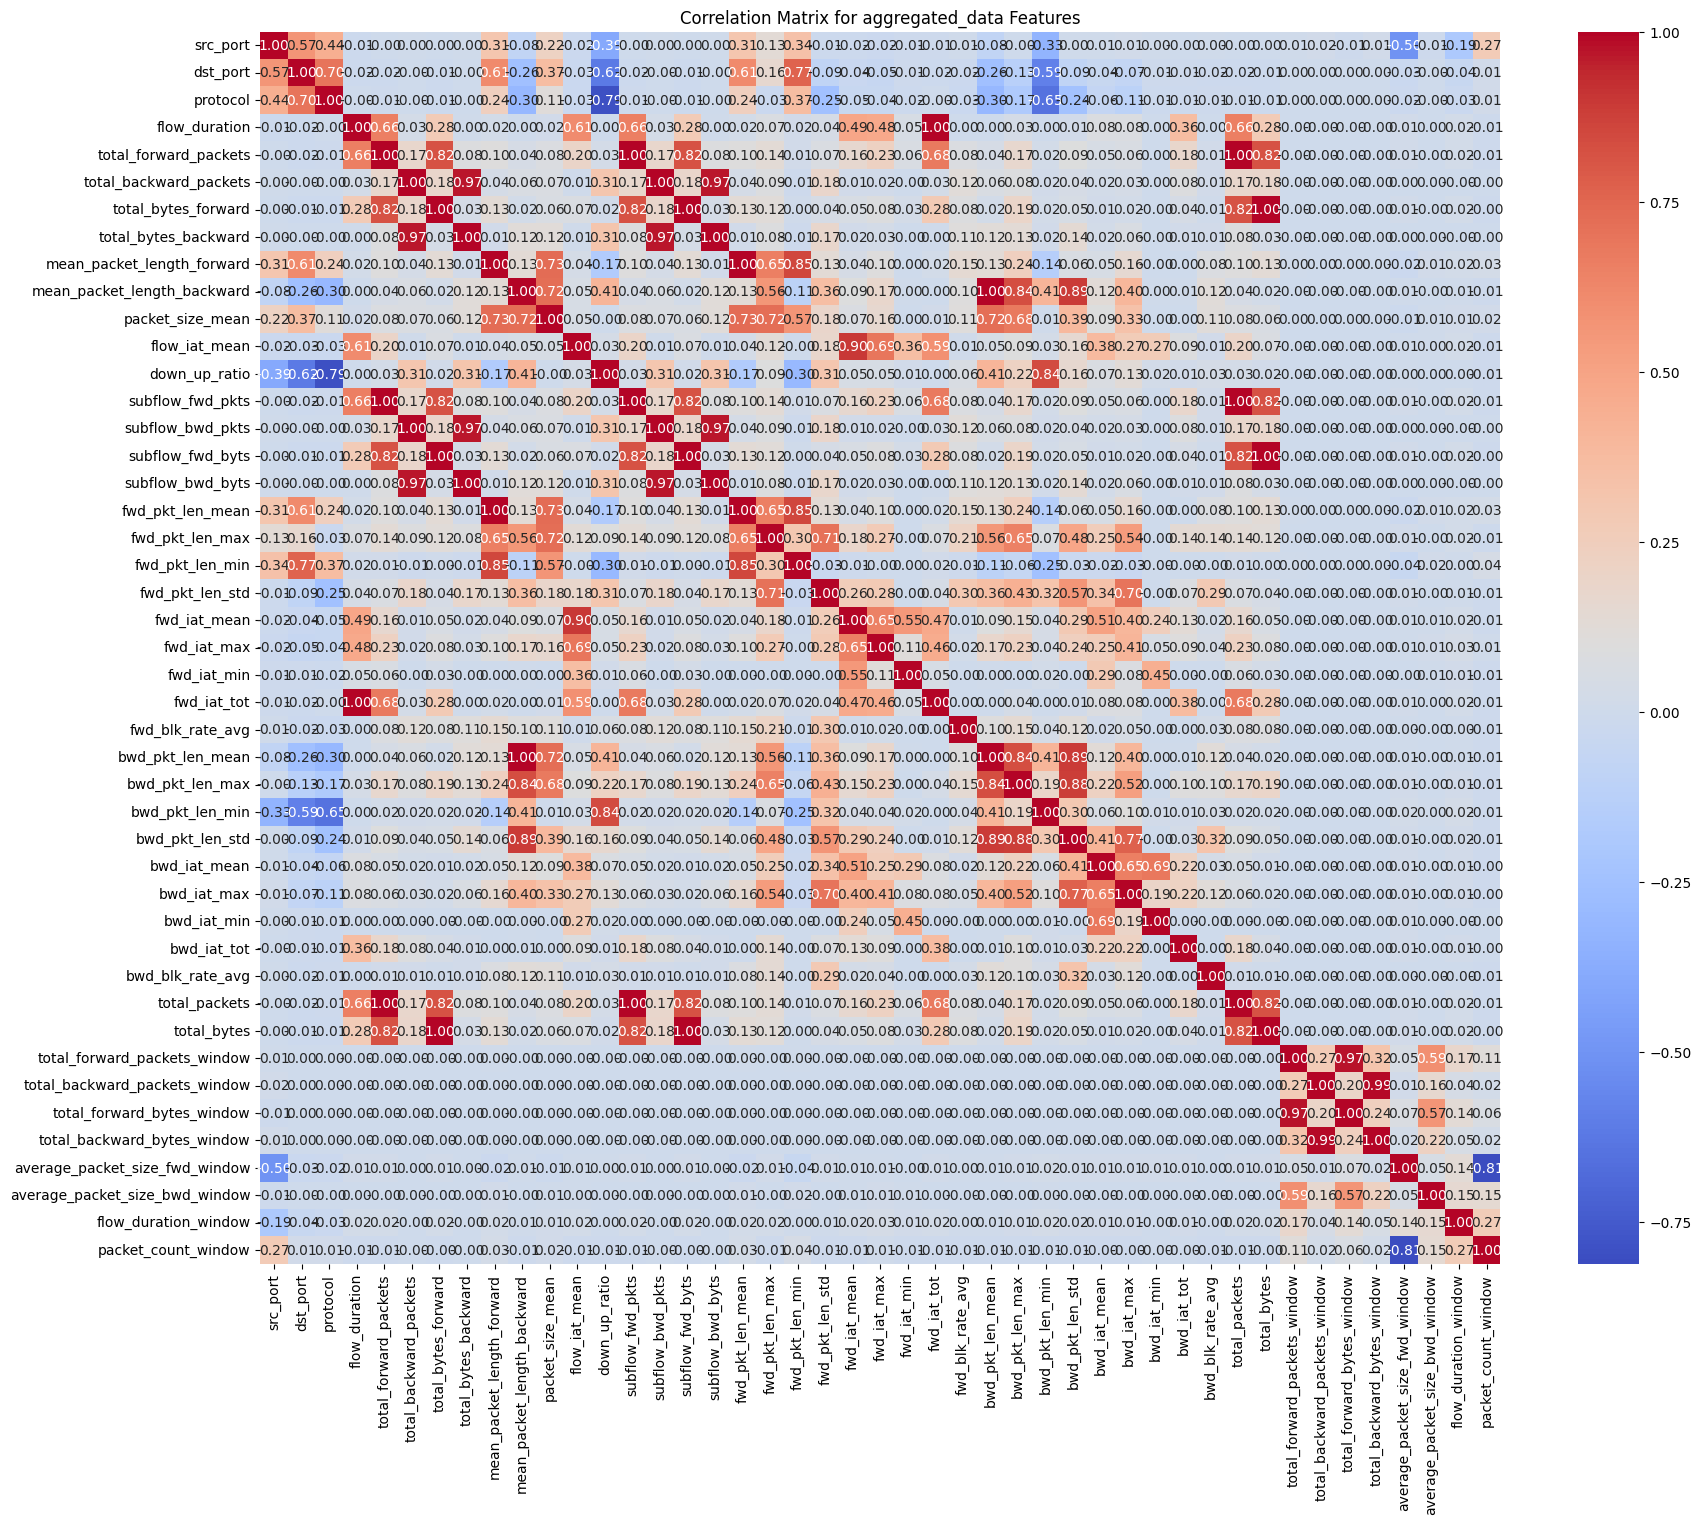

In [19]:
# Filter out non-numeric columns
numeric_columns = aggregated_data.select_dtypes(include='number')

# Generate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix for aggregated_data Features')
plt.show()

In [20]:
num_rows = aggregated_data.shape[0]
print(f"Number of rows in aggregated_data: {num_rows}")

Number of rows in aggregated_data: 54271


In [ ]:
# Merge the original DataFrame with aggregated_data to include the 'Label' feature
aggregated_data = aggregated_data.merge(data[['src_ip', 'dst_ip', 'Label']],
                                        on=['src_ip', 'dst_ip'],
                                        how='left')